
# Segmentation des étudiants selon leur santé mentale (K-Means)

Analyse exploratoire et segmentation non supervisée à partir du dataset **Student Mental health** afin d'identifier des profils homogènes d'étudiants pouvant guider des actions de prévention.



## Plan d'étude
1. Comprendre la structure du jeu de données et les distributions clés.
2. Préparer les variables (nettoyage, encodage, normalisation) conformément au cahier des charges.
3. Tester plusieurs valeurs de `K`, comparer l'inertie, la silhouette moyenne et l'indice de Davies-Bouldin.
4. Profiler les clusters retenus et proposer des visualisations/interprétations actionnables.


In [1]:

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
})

DATA_FILENAME = "Student Mental health.csv"
DEFAULT_DATA_PATH = Path("data") / DATA_FILENAME
ALT_DATA_PATH = Path.cwd().parent / "data" / DATA_FILENAME

if DEFAULT_DATA_PATH.exists():
    DATA_PATH = DEFAULT_DATA_PATH
elif ALT_DATA_PATH.exists():
    DATA_PATH = ALT_DATA_PATH
else:
    raise FileNotFoundError("Impossible de localiser le dataset 'Student Mental health.csv'.")

print(f"Lecture du dataset : {DATA_PATH}")
RANDOM_STATE = 42


Lecture du dataset : /mnt/c/Users/Yakubu/3D Objects/IFOAD_COURS/Machine Learning Non Supervisé/kmeans/data/Student Mental health.csv


In [2]:

raw_df = pd.read_csv(DATA_PATH)
print(f"Shape: {raw_df.shape}")
raw_df.head()


Shape: (101, 11)


,Timestamp,Choose your gender,Age,What is your course?,Your current year of Study,What is your CGPA?,Marital status,Do you have Depression?,Do you have Anxiety?,Do you have Panic attack?,Did you seek any specialist for a treatment?
0,8/7/2020 12:02,Female,18.0,Engineering,year 1,3.00 - 3.49,No,Yes,No,Yes,No
1,8/7/2020 12:04,Male,21.0,Islamic education,year 2,3.00 - 3.49,No,No,Yes,No,No
2,8/7/2020 12:05,Male,19.0,BIT,Year 1,3.00 - 3.49,No,Yes,Yes,Yes,No
3,8/7/2020 12:06,Female,22.0,Laws,year 3,3.00 - 3.49,Yes,Yes,No,No,No
4,8/7/2020 12:13,Male,23.0,Mathemathics,year 4,3.00 - 3.49,No,No,No,No,No


In [3]:

audit = pd.DataFrame({
    "dtype": raw_df.dtypes,
    "missing": raw_df.isna().sum(),
    "n_unique": raw_df.nunique(),
})
audit


,dtype,missing,n_unique
Timestamp,object,0,92
Choose your gender,object,0,2
Age,float64,1,7
What is your course?,object,0,49
Your current year of Study,object,0,7
What is your CGPA?,object,0,6
Marital status,object,0,2
Do you have Depression?,object,0,2
Do you have Anxiety?,object,0,2
Do you have Panic attack?,object,0,2


In [4]:

duplicate_count = raw_df.duplicated().sum()
missing_age = raw_df['Age'].isna().sum()
print(f"Duplicate rows: {duplicate_count}")
print(f"Missing ages: {missing_age}")

for column in raw_df.columns:
    vc = raw_df[column].value_counts(dropna=False).head(8)
    display(pd.DataFrame({"value": vc.index, "count": vc.values, "share": (vc.values / len(raw_df)).round(3)}))


Duplicate rows: 0
Missing ages: 1


,value,count,share
0,8/7/2020 12:39,3,0.03
1,8/7/2020 16:34,2,0.02
2,8/7/2020 14:43,2,0.02
3,8/7/2020 13:13,2,0.02
4,8/7/2020 14:57,2,0.02
5,8/7/2020 12:43,2,0.02
6,8/7/2020 15:14,2,0.02
7,8/7/2020 14:29,2,0.02


,value,count,share
0,Female,75,0.743
1,Male,26,0.257


,value,count,share
0,18.0,32,0.317
1,24.0,23,0.228
2,19.0,21,0.208
3,23.0,13,0.129
4,20.0,6,0.059
5,21.0,3,0.030
6,22.0,2,0.020
7,NaN,1,0.010


,value,count,share
0,BCS,18,0.178
1,Engineering,17,0.168
2,BIT,10,0.099
3,Biomedical science,4,0.040
4,KOE,4,0.040
5,BENL,2,0.020
6,Laws,2,0.020
7,psychology,2,0.020


,value,count,share
0,year 1,41,0.406
1,Year 3,19,0.188
2,Year 2,16,0.158
3,year 2,10,0.099
4,year 4,8,0.079
5,year 3,5,0.050
6,Year 1,2,0.020


,value,count,share
0,3.50 - 4.00,47,0.465
1,3.00 - 3.49,43,0.426
2,2.50 - 2.99,4,0.040
3,0 - 1.99,4,0.040
4,2.00 - 2.49,2,0.020
5,3.50 - 4.00,1,0.010


,value,count,share
0,No,85,0.842
1,Yes,16,0.158


,value,count,share
0,No,66,0.653
1,Yes,35,0.347


,value,count,share
0,No,67,0.663
1,Yes,34,0.337


,value,count,share
0,No,68,0.673
1,Yes,33,0.327


,value,count,share
0,No,95,0.941
1,Yes,6,0.059



### Visualisations exploratoires
Quelques graphes pour appréhender rapidement les distributions clés et les réponses de santé mentale.


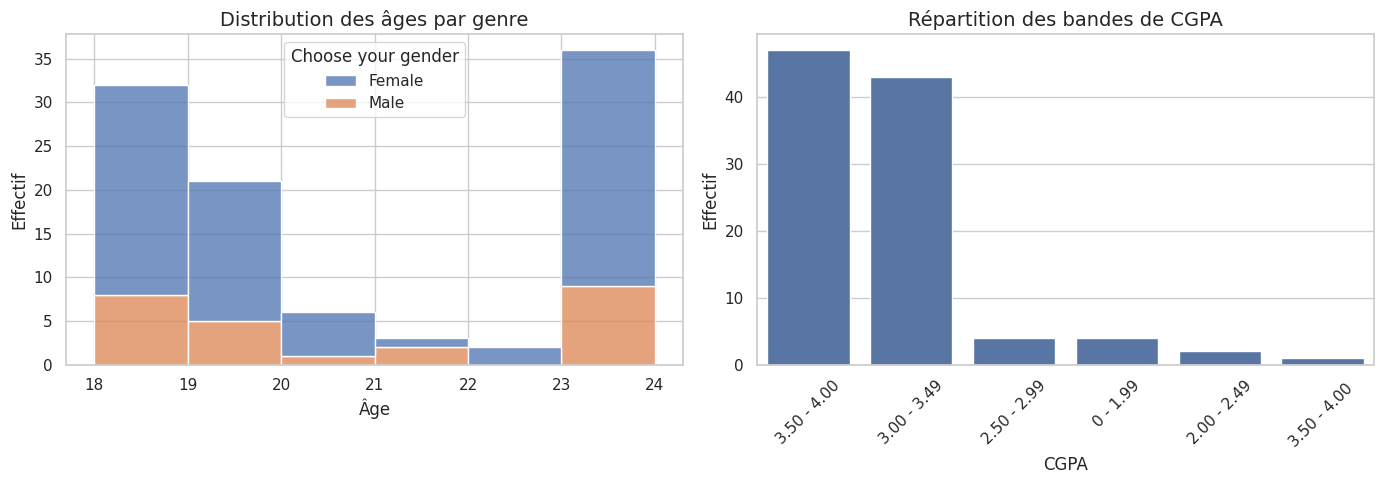

In [5]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data=raw_df, x="Age", hue="Choose your gender", multiple="stack", binwidth=1, ax=axes[0])
axes[0].set_title("Distribution des âges par genre")
axes[0].set_xlabel("Âge")
axes[0].set_ylabel("Effectif")

sns.countplot(data=raw_df, x="What is your CGPA?", order=raw_df["What is your CGPA?"].value_counts().index, ax=axes[1])
axes[1].set_title("Répartition des bandes de CGPA")
axes[1].set_xlabel("CGPA")
axes[1].set_ylabel("Effectif")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


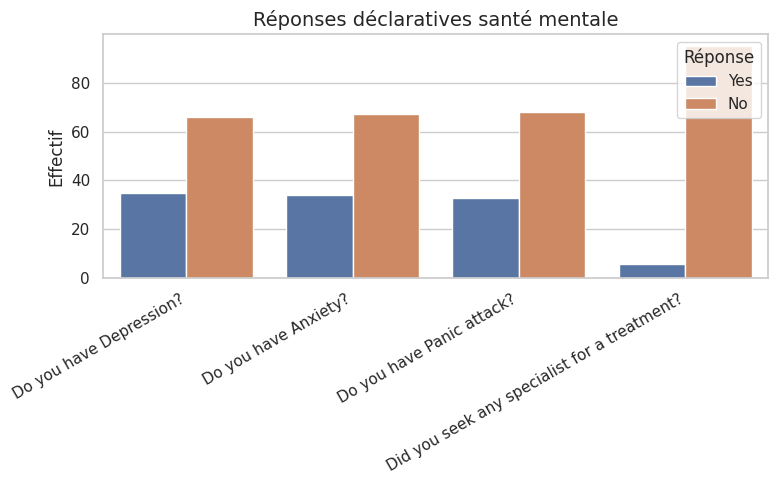

In [6]:

mental_cols = [
    "Do you have Depression?",
    "Do you have Anxiety?",
    "Do you have Panic attack?",
    "Did you seek any specialist for a treatment?",
]

mental_long = raw_df[mental_cols].melt(var_name="Question", value_name="Réponse")
plt.figure(figsize=(8, 5))
sns.countplot(data=mental_long, x="Question", hue="Réponse", order=mental_cols)
plt.xticks(rotation=30, ha="right")
plt.title("Réponses déclaratives santé mentale")
plt.ylabel("Effectif")
plt.xlabel("")
plt.legend(title="Réponse")
plt.tight_layout()
plt.show()



## Préparation & encodage
- harmonisation des libellés (genre, année d'étude, bandes de CGPA) ;
- conversion des variables binaires Oui/Non en 0/1 ;
- remplacement de l'unique valeur manquante d'âge par la médiane ;
- suppression des colonnes non explicatives (`Timestamp`) et des doublons éventuels.


In [7]:

import re

df = raw_df.copy()
rename_map = {
    "Choose your gender": "gender",
    "Age": "age",
    "What is your course?": "course",
    "Your current year of Study": "study_year",
    "What is your CGPA?": "cgpa_band",
    "Marital status": "married",
    "Do you have Depression?": "depression",
    "Do you have Anxiety?": "anxiety",
    "Do you have Panic attack?": "panic_attack",
    "Did you seek any specialist for a treatment?": "seeking_treatment",
}

df = df.rename(columns=rename_map)

def normalize_year(value: str) -> str:
    value = str(value).strip()
    digits = re.findall(r"\d+", value)
    if digits:
        return f"Year {digits[0]}"
    return value.title()

def cgpa_midpoint(value: str) -> float:
    value = str(value).strip()
    if "-" in value:
        low, high = [float(v) for v in value.split("-")]
        return round((low + high) / 2, 2)
    return float(value)

binary_map = {"Yes": 1, "No": 0}
binary_cols = ["married", "depression", "anxiety", "panic_attack", "seeking_treatment"]

for col in binary_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.title()
        .map(binary_map)
    )

df["gender"] = df["gender"].astype(str).str.strip().str.title()
df["course"] = df["course"].astype(str).str.strip()
df["study_year_clean"] = df["study_year"].apply(normalize_year)
df["cgpa_numeric"] = df["cgpa_band"].apply(cgpa_midpoint)

df["age"] = df["age"].fillna(df["age"].median())
df = df.drop(columns=["Timestamp"])
df = df.drop_duplicates()

feature_cols = [
    "age",
    "cgpa_numeric",
    *binary_cols,
    "gender",
    "course",
    "study_year_clean",
]
df_model = df[feature_cols].reset_index(drop=True)
df_model.head()


,age,cgpa_numeric,married,depression,anxiety,panic_attack,seeking_treatment,gender,course,study_year_clean
0,18.0,3.25,0,1,0,1,0,Female,Engineering,Year 1
1,21.0,3.25,0,0,1,0,0,Male,Islamic education,Year 2
2,19.0,3.25,0,1,1,1,0,Male,BIT,Year 1
3,22.0,3.25,1,1,0,0,0,Female,Laws,Year 3
4,23.0,3.25,0,0,0,0,0,Male,Mathemathics,Year 4



### Corrélations des variables numériques/binaires


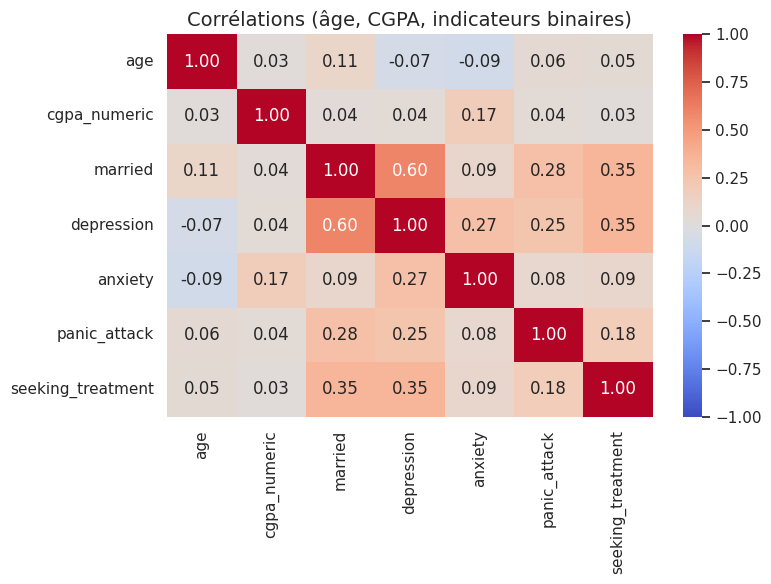

In [8]:

corr_cols = ["age", "cgpa_numeric", *binary_cols]
corr_matrix = df_model[corr_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Corrélations (âge, CGPA, indicateurs binaires)")
plt.tight_layout()
plt.show()


In [9]:

numeric_features = ["age", "cgpa_numeric", *binary_cols]
categorical_features = ["gender", "course", "study_year_clean"]

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", StandardScaler(), numeric_features),
        (
            "categorical",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
            categorical_features,
        ),
    ],
    remainder="drop",
)

X = preprocessor.fit_transform(df_model)
feature_names = preprocessor.get_feature_names_out()
print(f"Feature matrix shape: {X.shape}")
pd.DataFrame(X, columns=feature_names).head()


Feature matrix shape: (101, 58)


,numeric__age,numeric__cgpa_numeric,numeric__married,numeric__depression,numeric__anxiety,numeric__panic_attack,numeric__seeking_treatment,categorical__gender_Male,categorical__course_Accounting,categorical__course_BCS,...,categorical__course_Psychology,categorical__course_Radiography,categorical__course_TAASL,categorical__course_Usuluddin,categorical__course_engin,categorical__course_koe,categorical__course_psychology,categorical__study_year_clean_Year 2,categorical__study_year_clean_Year 3,categorical__study_year_clean_Year 4
0,-1.015659,-0.18637,-0.433861,1.373213,-0.712364,1.435481,-0.251312,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.195934,-0.18637,-0.433861,-0.728219,1.403776,-0.696631,-0.251312,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.611794,-0.18637,-0.433861,1.373213,1.403776,1.435481,-0.251312,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.599799,-0.18637,2.304886,1.373213,-0.712364,-0.696631,-0.251312,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.003663,-0.18637,-0.433861,-0.728219,-0.712364,-0.696631,-0.251312,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:

results = []
for k in range(2, 9):
    model = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=50,
        random_state=RANDOM_STATE,
    )
    labels = model.fit_predict(X)
    results.append({
        "k": k,
        "inertia": model.inertia_,
        "silhouette": silhouette_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels),
    })

metrics_df = pd.DataFrame(results)
metrics_df


,k,inertia,silhouette,davies_bouldin
0,2,693.241306,0.301620,1.616006
1,3,602.750369,0.169949,1.792674
2,4,526.185485,0.198954,1.558433
3,5,455.017855,0.223115,1.440257
4,6,405.194491,0.203052,1.395886
5,7,371.298280,0.198607,1.322081
6,8,340.017893,0.210470,1.349108


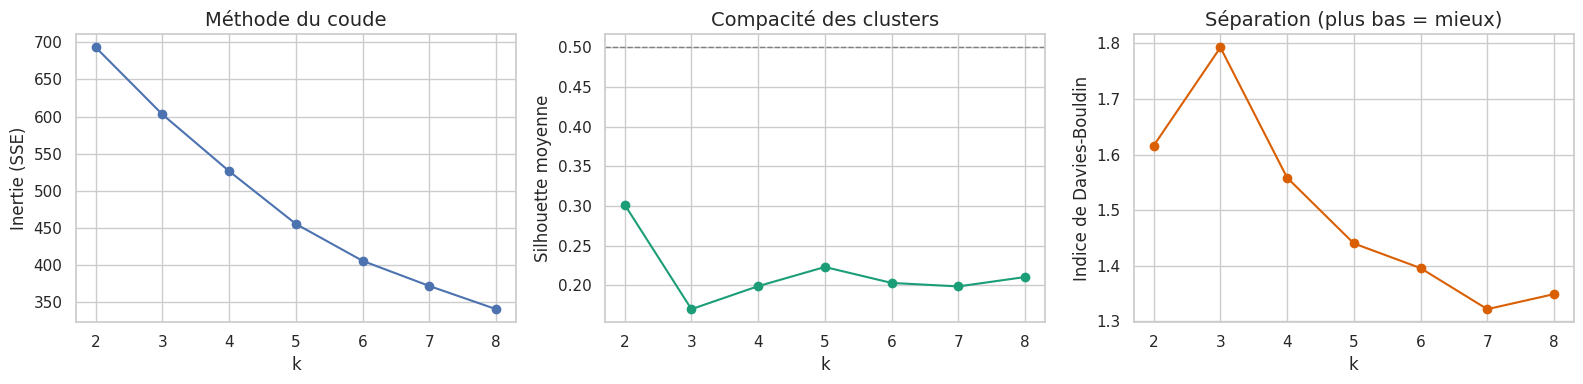

In [11]:

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes = axes.ravel()
axes[0].plot(metrics_df["k"], metrics_df["inertia"], marker="o")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Inertie (SSE)")
axes[0].set_title("Méthode du coude")

axes[1].plot(metrics_df["k"], metrics_df["silhouette"], marker="o", color="#1b9e77")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Silhouette moyenne")
axes[1].axhline(0.5, ls="--", color="gray", lw=1)
axes[1].set_title("Compacité des clusters")

axes[2].plot(metrics_df["k"], metrics_df["davies_bouldin"], marker="o", color="#d95f02")
axes[2].set_xlabel("k")
axes[2].set_ylabel("Indice de Davies-Bouldin")
axes[2].set_title("Séparation (plus bas = mieux)")

plt.tight_layout()
plt.show()


In [12]:

metrics_df["silhouette_rank"] = metrics_df["silhouette"].rank(ascending=False)
metrics_df["db_rank"] = metrics_df["davies_bouldin"].rank(ascending=True)
metrics_df["combined_rank"] = metrics_df[["silhouette_rank", "db_rank"]].mean(axis=1)

best_row = metrics_df.sort_values("combined_rank").iloc[0]
best_k = int(best_row["k"])
print(f"Meilleur compromis identifié: k = {best_k}")
metrics_df.sort_values("combined_rank")


Meilleur compromis identifié: k = 8


,k,inertia,silhouette,davies_bouldin,silhouette_rank,db_rank,combined_rank
6,8,340.017893,0.210470,1.349108,3.0,2.0,2.5
3,5,455.017855,0.223115,1.440257,2.0,4.0,3.0
0,2,693.241306,0.301620,1.616006,1.0,6.0,3.5
4,6,405.194491,0.203052,1.395886,4.0,3.0,3.5
5,7,371.298280,0.198607,1.322081,6.0,1.0,3.5
2,4,526.185485,0.198954,1.558433,5.0,5.0,5.0
1,3,602.750369,0.169949,1.792674,7.0,7.0,7.0


In [13]:

best_model = KMeans(
    n_clusters=best_k,
    init="k-means++",
    n_init=100,
    random_state=RANDOM_STATE,
)
cluster_labels = best_model.fit_predict(X)

clustered_df = df_model.copy()
clustered_df["cluster"] = cluster_labels
cluster_sizes = clustered_df["cluster"].value_counts().sort_index()
print("Cluster sizes:")
print(cluster_sizes)
clustered_df.head()


Cluster sizes:
cluster
0    18
1    22
2    12
3    10
4     6
5     4
6    16
7    13
Name: count, dtype: int64


,age,cgpa_numeric,married,depression,anxiety,panic_attack,seeking_treatment,gender,course,study_year_clean,cluster
0,18.0,3.25,0,1,0,1,0,Female,Engineering,Year 1,7
1,21.0,3.25,0,0,1,0,0,Male,Islamic education,Year 2,6
2,19.0,3.25,0,1,1,1,0,Male,BIT,Year 1,3
3,22.0,3.25,1,1,0,0,0,Female,Laws,Year 3,2
4,23.0,3.25,0,0,0,0,0,Male,Mathemathics,Year 4,0


In [14]:

profile_numeric_cols = ["age", "cgpa_numeric", *binary_cols]
cluster_profiles = clustered_df.groupby("cluster")[profile_numeric_cols].mean().round(3)
cluster_profiles.rename(columns={
    "age": "age_mean",
    "cgpa_numeric": "cgpa_mean",
    "married": "married_share",
    "depression": "depression_share",
    "anxiety": "anxiety_share",
    "panic_attack": "panic_share",
    "seeking_treatment": "treatment_share",
}, inplace=True)
cluster_profiles


,age_mean,cgpa_mean,married_share,depression_share,anxiety_share,panic_share,treatment_share
cluster,,,,,,,
0,23.333,3.472,0.000,0.111,0.000,0.000,0.0
1,18.591,3.409,0.000,0.182,0.000,0.000,0.0
2,20.750,3.458,1.000,1.000,0.417,0.583,0.0
3,19.600,3.350,0.000,1.000,1.000,0.500,0.0
4,21.000,3.417,0.667,1.000,0.500,0.667,1.0
5,20.000,0.990,0.000,0.000,0.000,0.250,0.0
6,20.438,3.562,0.000,0.000,1.000,0.188,0.0
7,20.385,3.481,0.000,0.077,0.000,1.000,0.0


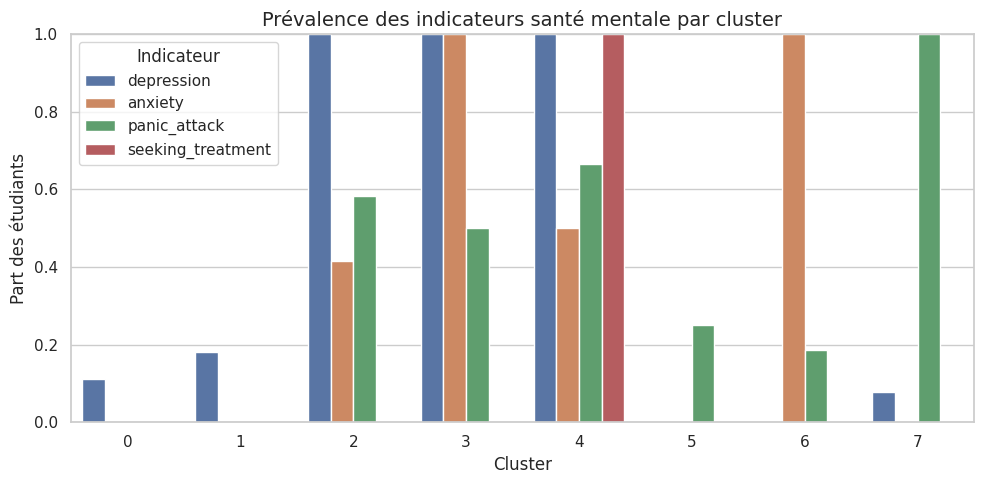

In [15]:

mh_cols = ["depression", "anxiety", "panic_attack", "seeking_treatment"]
rate_df = clustered_df.groupby("cluster")[mh_cols].mean().reset_index().melt(id_vars="cluster", var_name="metric", value_name="share")
plt.figure(figsize=(10, 5))
sns.barplot(data=rate_df, x="cluster", y="share", hue="metric")
plt.title("Prévalence des indicateurs santé mentale par cluster")
plt.ylabel("Part des étudiants")
plt.xlabel("Cluster")
plt.ylim(0, 1)
plt.legend(title="Indicateur")
plt.tight_layout()
plt.show()


In [16]:

def top_modalities(series, top_n=3):
    counts = series.value_counts(normalize=True).head(top_n)
    return ", ".join([f"{idx} ({share:.0%})" for idx, share in counts.items()])

categorical_summary = []
for cluster_id, group in clustered_df.groupby("cluster"):
    categorical_summary.append({
        "cluster": cluster_id,
        "gender_mix": top_modalities(group["gender"], top_n=2),
        "top_courses": top_modalities(group["course"], top_n=3),
        "study_year_mix": top_modalities(group["study_year_clean"], top_n=3),
    })

pd.DataFrame(categorical_summary).sort_values("cluster")


,cluster,gender_mix,top_courses,study_year_mix
0,0,"Female (67%), Male (33%)","BCS (28%), Engineering (17%), Mathemathics (6%)","Year 1 (44%), Year 4 (22%), Year 3 (17%)"
1,1,"Female (86%), Male (14%)","BCS (18%), Engineering (18%), Biomedical scien...","Year 1 (55%), Year 2 (27%), Year 4 (9%)"
2,2,"Female (83%), Male (17%)","Engineering (17%), Laws (8%), Pendidikan islam...","Year 3 (50%), Year 2 (42%), Year 4 (8%)"
3,3,"Female (80%), Male (20%)","BIT (30%), Engineering (20%), BCS (10%)","Year 1 (60%), Year 3 (30%), Year 2 (10%)"
4,4,"Female (83%), Male (17%)","BCS (33%), BIT (17%), Engineering (17%)","Year 1 (50%), Year 2 (33%), Year 3 (17%)"
5,5,"Male (50%), Female (50%)","BIT (25%), Biomedical science (25%), Biotechno...","Year 1 (50%), Year 3 (50%)"
6,6,"Female (62%), Male (38%)","BCS (25%), BIT (25%), KOE (12%)","Year 1 (44%), Year 2 (31%), Year 3 (19%)"
7,7,"Female (69%), Male (31%)","Engineering (31%), BCS (15%), TAASL (8%)","Year 1 (38%), Year 2 (31%), Year 3 (31%)"


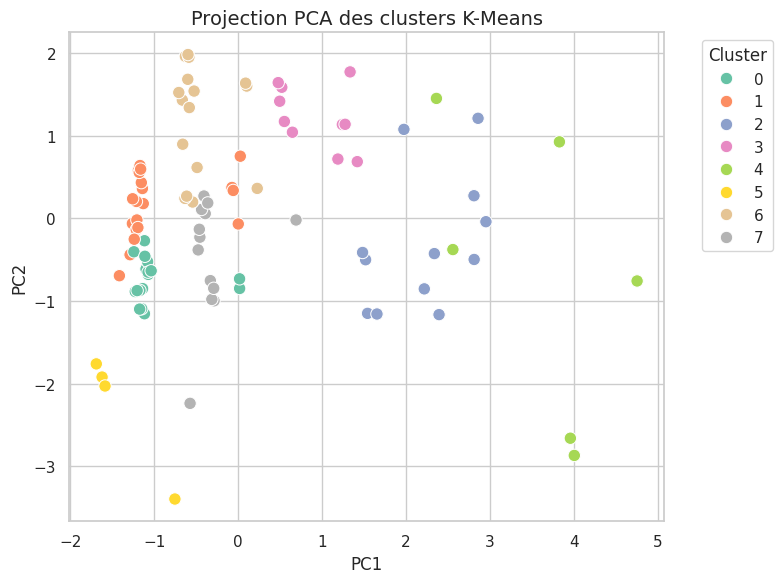

In [17]:

pca = PCA(n_components=2, random_state=RANDOM_STATE)
components = pca.fit_transform(X)
plot_df = pd.DataFrame({
    "PC1": components[:, 0],
    "PC2": components[:, 1],
    "cluster": cluster_labels,
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="cluster", palette="Set2", s=80)
plt.title("Projection PCA des clusters K-Means")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [18]:
report_lines = []
for cluster_id, row in cluster_profiles.reset_index().sort_values("cluster").iterrows():
    dominant_courses = top_modalities(clustered_df[clustered_df["cluster"] == cluster_id]["course"], top_n=2)
    dominant_years = top_modalities(clustered_df[clustered_df["cluster"] == cluster_id]["study_year_clean"], top_n=2)
    text = (
        f"Cluster {cluster_id} — âge moyen {row['age_mean']:.1f}, CGPA moyen {row['cgpa_mean']:.2f}. "
        f"Dépression {row['depression_share']:.0%}, anxiété {row['anxiety_share']:.0%}, panic attack {row['panic_share']:.0%}. "
        f"Cours dominants: {dominant_courses}. Années d'étude dominantes: {dominant_years}."
    )
    report_lines.append(text)

print("\n\n".join(report_lines))

Cluster 0 — âge moyen 23.3, CGPA moyen 3.47. Dépression 11%, anxiété 0%, panic attack 0%. Cours dominants: BCS (28%), Engineering (17%). Années d'étude dominantes: Year 1 (44%), Year 4 (22%).

Cluster 1 — âge moyen 18.6, CGPA moyen 3.41. Dépression 18%, anxiété 0%, panic attack 0%. Cours dominants: BCS (18%), Engineering (18%). Années d'étude dominantes: Year 1 (55%), Year 2 (27%).

Cluster 2 — âge moyen 20.8, CGPA moyen 3.46. Dépression 100%, anxiété 42%, panic attack 58%. Cours dominants: Engineering (17%), Laws (8%). Années d'étude dominantes: Year 3 (50%), Year 2 (42%).

Cluster 3 — âge moyen 19.6, CGPA moyen 3.35. Dépression 100%, anxiété 100%, panic attack 50%. Cours dominants: BIT (30%), Engineering (20%). Années d'étude dominantes: Year 1 (60%), Year 3 (30%).

Cluster 4 — âge moyen 21.0, CGPA moyen 3.42. Dépression 100%, anxiété 50%, panic attack 67%. Cours dominants: BCS (33%), BIT (17%). Années d'étude dominantes: Year 1 (50%), Year 2 (33%).

Cluster 5 — âge moyen 20.0, CGPA 

## Analyse approfondie des clusters

- **C2 & C3 – stress académiques avancés vs primo-entrants** : deux segments présentent 100 % de dépression mais pour des dynamiques différentes. C2 regroupe surtout les années 3/4 (Engineering, Law, etc.) avec un CGPA ~3.46, signe d’une pression de validation finale (projets, stage, insertion). C3 combine les Year 1 BIT/Engineering avec 100 % dépression + anxiété – reflet du choc d’entrée dans des filières STEM exigeantes. Actions proposées : cellule « transition » pour les Year 1 et dispositif « fin de cycle » (coaching carrière, gestion stress soutenance) pour les Year 3+.
- **C7 – panic attack généralisé** : Engineering/BCS années 1–3, CGPA ~3.48. Les crises de panique surviennent malgré la réussite académique, probablement à cause de la charge horaire et des projets compétitifs. Recommandation : ateliers respiration/gestion de crise intégrés aux cours et coordination avec les responsables pour lisser les échéances.
- **C4 – santé mentale clinique déjà suivie** : 100 % ont consulté un spécialiste, mix Year 1–3, CGPA ~3.42. Il faut assurer la continuité soins-études (flexibilité des délais, orchestration des modules théoriques) afin d’éviter les rechutes.
- **C6 – anxiété de performance** : anxiété 100 %, dépression 0 %, CGPA ~3.56 (Year 1/2 BCS/BIT/KOE). Les étudiants cherchent à maintenir un classement élevé : mentorat par pairs, ateliers « growth mindset » et hygiène de travail sont recommandés.
- **C5 – échec académique isolé** : CGPA ~1.0, effectif 4 (Year 1/3). Symptômes mentaux faibles mais risque d’abandon élevé. Actions : coaching individuel, aide sociale, réorientation accompagnée.
- **C0 & C1 – segments ressources** : profils stables (18–23 ans, CGPA >3.4). Ils peuvent devenir ambassadeurs bien-être/tuteurs pour C3/C5.
- **Effet programme/année** : Engineering, BCS, BIT sont surreprésentés dans les clusters critiques (C2, C3, C4, C6, C7), ce qui confirme que ces filières concentrent les contraintes. L’année d’étude module la symptomatologie (adaptation en Year 1, pression finale en Year 3, préparation insertion en Year 4). D’où l’importance d’une stratégie multi-niveaux.
- **Lien CGPA/santé mentale** : C5 montre qu’un faible CGPA peut se produire sans détresse déclarée, tandis que C2/C4 rappellent qu’un bon CGPA ne protège pas contre les troubles. Il ne faut donc pas conditionner l’accès au soutien à la performance académique.


## Variantes de clustering (K réduit et hiérarchique)
Afin de tester la robustesse des segments, on compare K-Means pour K=3 à K=6 et une approche hiérarchique (Ward, K=4).

In [19]:

alt_results = []
for k in range(3, 7):
    model = KMeans(n_clusters=k, init="k-means++", n_init=150, random_state=RANDOM_STATE)
    labels = model.fit_predict(X)
    alt_results.append({
        "model": f"kmeans_{k}",
        "k": k,
        "silhouette": silhouette_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels),
    })

agg_model = AgglomerativeClustering(n_clusters=4, linkage="ward")
agg_labels = agg_model.fit_predict(X)
alt_results.append({
    "model": "agglo_ward_4",
    "k": 4,
    "silhouette": silhouette_score(X, agg_labels),
    "davies_bouldin": davies_bouldin_score(X, agg_labels),
})

alt_df = pd.DataFrame(alt_results).sort_values("silhouette", ascending=False).reset_index(drop=True)
alt_df


,model,k,silhouette,davies_bouldin
0,agglo_ward_4,4,0.235461,1.477017
1,kmeans_5,5,0.223115,1.440257
2,kmeans_6,6,0.203052,1.395886
3,kmeans_4,4,0.198954,1.558433
4,kmeans_3,3,0.169949,1.792674


In [20]:

profile_numeric_cols = ["age", "cgpa_numeric", *binary_cols]

k5_model = KMeans(n_clusters=5, init="k-means++", n_init=150, random_state=RANDOM_STATE)
k5_labels = k5_model.fit_predict(X)

k5_df = df_model.copy()
k5_df["cluster"] = k5_labels

k5_profiles = k5_df.groupby("cluster")[profile_numeric_cols].mean().round(3)
k5_profiles.rename(columns={
    "age": "age_mean",
    "cgpa_numeric": "cgpa_mean",
    "married": "married_share",
    "depression": "depression_share",
    "anxiety": "anxiety_share",
    "panic_attack": "panic_share",
    "seeking_treatment": "treatment_share",
}, inplace=True)

print("Clusters K=5 (effectifs):")
print(k5_df["cluster"].value_counts().sort_index())
display(k5_profiles)

def describe_modalities(series, top_n=3):
    counts = series.value_counts(normalize=True).head(top_n)
    return ", ".join([f"{idx} ({share:.0%})" for idx, share in counts.items()])

cat_rows = []
for cluster_id, group in k5_df.groupby("cluster"):
    cat_rows.append({
        "cluster": cluster_id,
        "top_courses": describe_modalities(group["course"]),
        "top_years": describe_modalities(group["study_year_clean"]),
    })

display(pd.DataFrame(cat_rows).sort_values("cluster"))


Clusters K=5 (effectifs):
cluster
0    26
1    51
2     6
3    12
4     6
Name: count, dtype: int64


,age_mean,cgpa_mean,married_share,depression_share,anxiety_share,panic_share,treatment_share
cluster,,,,,,,
0,20.115,3.481,0.000,0.385,1.000,0.308,0.0
1,20.627,3.495,0.000,0.137,0.000,0.235,0.0
2,21.000,3.417,0.667,1.000,0.500,0.667,1.0
3,20.750,3.458,1.000,1.000,0.417,0.583,0.0
4,20.333,1.410,0.000,0.000,0.000,0.333,0.0


,cluster,top_courses,top_years
0,0,"BIT (27%), BCS (19%), Engineering (12%)","Year 1 (50%), Year 2 (23%), Year 3 (23%)"
1,1,"BCS (22%), Engineering (18%), Biomedical scien...","Year 1 (47%), Year 2 (24%), Year 3 (18%)"
2,2,"BCS (33%), BIT (17%), Engineering (17%)","Year 1 (50%), Year 2 (33%), Year 3 (17%)"
3,3,"Engineering (17%), Laws (8%), Pendidikan islam...","Year 3 (50%), Year 2 (42%), Year 4 (8%)"
4,4,"Engineering (33%), BIT (17%), Biomedical scien...","Year 1 (50%), Year 3 (33%), Year 2 (17%)"



## Pistes d'interprétation & suites
- Utiliser le tableau des profils + la synthèse textuelle ci-dessus pour positionner chaque segment (ex. étudiants plus jeunes en année 1 vs profils avancés) et prioriser les actions de prévention.
- Rejouer facilement le notebook avec d'autres valeurs de `k` ou variables explicatives supplémentaires (ex. scinder les filières STEM/non-STEM) en ajustant la liste `feature_cols`.
- Prévoir une validation qualitative avec les équipes pédagogiques afin de relier chaque cluster à des besoins métiers concrets (ateliers, communication ciblée, etc.).
